# Baseline Model Evaluation

In [2]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
import os



c:\Users\zfeng\OneDrive\Documents\FYP\fit3163-fyp\fyp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Clean Data

In [3]:
processed_df = pd.read_csv('input/01_ingestion_and_eda.csv')

In [4]:
processed_df.drop(columns=['icd_code','icd_version'], inplace=True)

## Minimal Processing

In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import TransformerMixin



# Define feature categories
num_features = ["heartrate", "resprate", "o2sat", "sbp", "dbp", "anchor_age"]
binary_features = ["NIHSS_Score", "gender"]

### **Custom Transformer to Convert Back to DataFrame**
class DataFrameTransformer(TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)

# **Pipeline for Numerical Features**
num_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("to_dataframe", DataFrameTransformer(feature_names=num_features))  # Convert back to DataFrame
])

# **Pipeline for Categorical Features**
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("to_dataframe", DataFrameTransformer(feature_names=[]))  # Placeholder, feature names will be added dynamically
])

# **Process Binary Features (pass through)**
binary_pipeline = Pipeline([
    ("to_dataframe", DataFrameTransformer(feature_names=binary_features))  # Keep binary as is
])

# **Fit Transformers**
num_transformed = num_pipeline.fit_transform(processed_df[num_features])

cat_encoder = cat_pipeline.named_steps["encoder"]

# Extract feature names from OneHotEncoder
binary_transformed = binary_pipeline.fit_transform(processed_df[binary_features])

# **Concatenate all transformed data into a DataFrame**
final_df = pd.concat([num_transformed, binary_transformed], axis=1)

# Display the transformed DataFrame
print(final_df.head())


   heartrate  resprate     o2sat       sbp       dbp  anchor_age  NIHSS_Score  \
0   0.437764  0.427595  0.991451 -0.813971  0.362319    0.154246            3   
1  -0.058902  1.461811  0.484111  2.239585  0.515790    0.953238            0   
2   2.300261  2.496028  0.484111  0.630279  0.311162    0.207512            4   
3   0.934430 -0.606621  0.991451  0.300165  0.669261   -0.165351            0   
4   0.561931  0.082856 -0.023230 -0.029950  1.590088   -0.751279            0   

   gender  
0       0  
1       1  
2       0  
3       0  
4       0  


### Stratified Split 
- First Split (80% train + 20% test)
- Second Split (80% train, 20% validation)


In [7]:
y = final_df["NIHSS_Score"]
X = final_df.drop(columns=["NIHSS_Score"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [8]:
X

,heartrate,resprate,o2sat,sbp,dbp,anchor_age,gender
0,0.437764,0.427595,0.991451,-0.813971,0.362319,0.154246,0
1,-0.058902,1.461811,0.484111,2.239585,0.515790,0.953238,1
2,2.300261,2.496028,0.484111,0.630279,0.311162,0.207512,0
3,0.934430,-0.606621,0.991451,0.300165,0.669261,-0.165351,0
4,0.561931,0.082856,-0.023230,-0.029950,1.590088,-0.751279,0
...,...,...,...,...,...,...,...
23930,-1.114317,-0.606621,0.991451,-0.648914,0.618104,-1.603537,1
23931,0.748180,0.772334,-1.037910,-0.937763,0.720418,-0.911077,1
23932,1.151721,0.082856,-1.291580,-0.483856,0.592526,-0.325149,0
23933,1.555262,-0.606621,-1.545250,-0.029950,0.464633,0.314044,0


In [9]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


## Baseline Model Training

In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# calculate metrics for validation set
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_accuracy = accuracy_score(y_val, y_val_pred)

# calculate metrics for test set
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Validation Metrics:")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print()
print("Test Metrics:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

Validation Metrics:
F1 Score: 0.9874
Precision: 0.9878
Recall: 0.9875
Accuracy: 0.9875

Test Metrics:
F1 Score: 0.8448
Precision: 0.8445
Recall: 0.8456
Accuracy: 0.8456


### SHAP and LIME Analysis

#### SHAP

In [12]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


<Figure size 640x480 with 0 Axes>

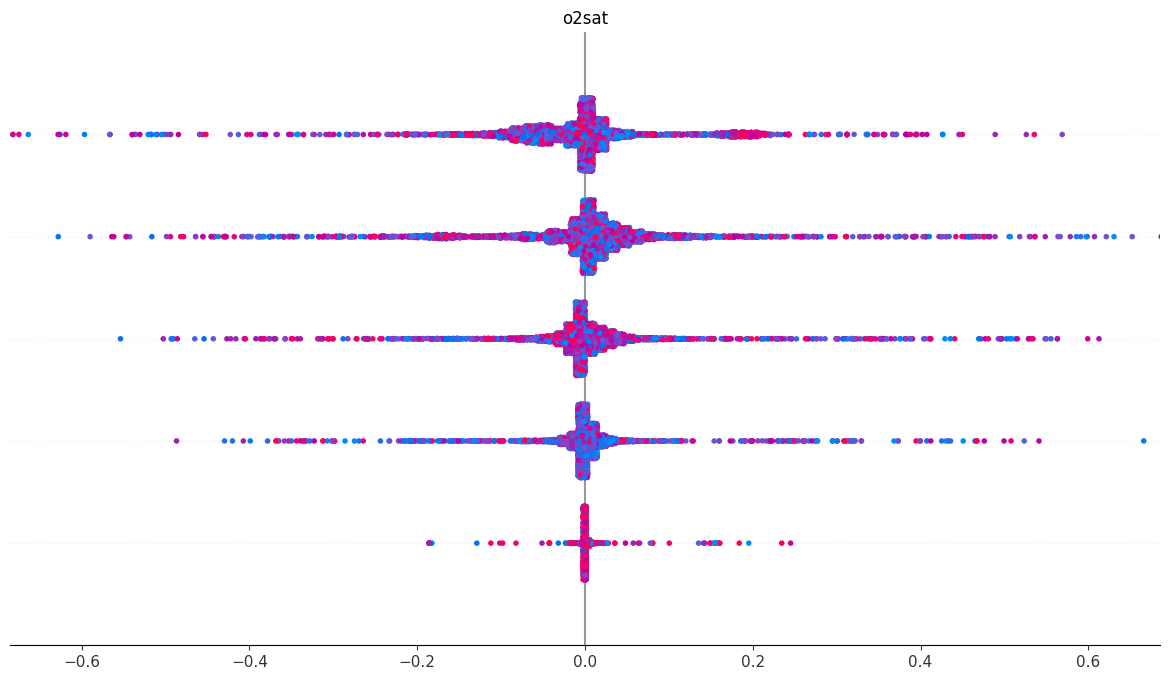

In [13]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [14]:
X_test

,heartrate,resprate,o2sat,sbp,dbp,anchor_age,gender
16227,-0.245152,-0.261882,0.230440,-0.607649,-0.711979,-0.325149,1
17519,-0.431401,-1.296099,-1.545250,-1.886842,0.157691,0.740174,1
4622,-0.431401,-0.606621,-2.052591,-0.401328,0.106534,-0.911077,1
9517,0.810264,-0.606621,-0.023230,-0.112478,-0.456194,-2.189465,1
3903,-1.052234,-0.951360,0.484111,0.258900,-0.507351,-0.378416,1
...,...,...,...,...,...,...,...
4821,-0.058902,-0.606621,-0.023230,-1.350406,-0.865450,-1.816602,1
23767,-1.176400,0.082856,-1.545250,-0.236271,-1.223550,1.645698,1
4511,1.679429,0.082856,0.484111,0.135107,0.720418,-0.165351,0
21770,0.313598,-0.606621,-0.023230,-1.061556,-0.763136,-2.189465,1


##### Dependence Plot Insights

Notes:

Restaurants Class :
- amount feature has a strong positive relationship with the SHAP value especially when the day feature is high.

Third Party Class :
- amount feature also shows a positive relationship with the SHAP value, but the impact is bigger when the month feature is higher 

Uncategorized Class :
- amount feature again exhibits a positive relationship with the SHAP value, with a stronger effect when the bank_id feature is higher

**Observations**

- there is a consistent positive relationship between the amount feature and the SHAP value, indicating that higher transaction amounts generally increase the likelihood of being classified into each respective class

- the impact of the amount feature varies depending on the values of other features 


**Key Takeaway**

- the amount feature plays a crucial role in determining the class of transactions across all categories
- larger transaction amounts tend to increase the probability of belonging to each class.
-  "Restaurants" class is influenced by the day feature, while the "Third Party" class is more affected by the month feature. This highlights the need for class-specific analysis when interpreting model predictions.


#### LIME

In [15]:
explainer_lime = LimeTabularExplainer(
    X_train.values, 
    training_labels=y_train, 
    feature_names=X.columns, 
    class_names=class_mapping, 
    discretize_continuous=True
)
lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
lime_explanation.as_pyplot_figure()
plt.show()


NameError: name 'class_mapping' is not defined

##### Insights
**Observations**

-  majority of the features have a negative impact on the prediction, indicating that the instance has characteristics that are not typical of "class 1"

- features like day_of_week, month, and account_id have small positive contributions, suggests some characteristics that align with "class 1"

**Key Takeaway**
- more or less the same with shap just that mayble higher account IDs might be slightly more likely to be classified as "class 1", but the effect is marginal

### Model Tracking With MLFlow

In [ ]:
# set MLflow tracking URI & Experiment
mlflow.set_tracking_uri("http://127.0.0.1:8080")  
mlflow.set_experiment("Transaction Classification")

<Experiment: artifact_location='mlflow-artifacts:/715835200665664301', creation_time=1739038980493, experiment_id='715835200665664301', last_update_time=1739038980493, lifecycle_stage='active', name='Transaction Classification', tags={}>

In [ ]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [ ]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'preprocessed_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source i

In [ ]:
# logging with MLflow

data_source_path = "preprocessed_data.csv"

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    #log artifacts, no parameters to log yet
    mlflow.log_artifact(data_source_path, artifact_path="model_data")

    
    # log tags 
    mlflow.set_tags({
        "model_type": "RandomForest",  
        "framework": "sklearn",        
        "experiment_name": "Model_Experiment",  
        "random_state": "42"  
    })

    # log parameter source code
    mlflow.log_param("source_code", "train_model.py")  # Replace with your actual script/file

    # log model
    mlflow.sklearn.log_model(model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/02/10 17:02:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto

🏃 View run glamorous-shark-788 at: http://127.0.0.1:8080/#/experiments/715835200665664301/runs/2e7e668607794bd9b205c3f6a7eba872
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/715835200665664301
